In [1]:
# Data packages
import pandas as pd 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

from model.rnn import GRUDecoder
from model.autoencoder import TabularEncoder
from data_processing.pipeline import encoding_pipeline, get_generic_name

import torch.nn as nn
import torch.nn.functional as F

import umap.umap_ as umap
import matplotlib.pyplot as plt
from model.utils import get_device, generate_predictions, generate_contrastive_task

/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = get_device()

Using MPS (Metal Performance Shaders) device


# Read the data

Right now the notebook is set to work with fake data. This can be changed once the pipeline works.

The data is stored as a Dict[person_id, Sequences] where Sequences is a Dict[year, survery_wave_response]

In [3]:
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

In [4]:
importance = pd.read_csv('features_importance_1000.csv')
custom_pairs = importance.iloc[:250].feature.map(lambda x: get_generic_name(x))
"Unique columns count: %s" %len(set(custom_pairs))

'Unique columns count: 205'

In [6]:
# check if sequences have been preprocessed (saves time)
if False: #os.path.exists('data/processed_data/sequences.pt'):
    sequences = torch.load('data/processed_data/sequences.pt')
else:
    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs, use_codebook=True)
    #torch.save(sequences, 'data/processed_data/sequences.pt')

/Users/carlomarx/Documents/GitHub/fertility-prediction-challenge/data_processing/pipeline.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


In [7]:
from model.dataset import PretrainingDataset
pretrain_dataset = PretrainingDataset(sequences)

## Pretraining

In [8]:
### Initialization of the Autoencoder 
#ENCODING_SIZE = 64
BATCH_SIZE = 128
HIDDEN_SIZE = 64
ENCODING_SIZE = 64
NUM_HEADS = 4
NUM_LAYERS = 4
DETECT_ANOMALY = False
SEQ_LEN = pretrain_dataset.get_seq_len()
VOCAB_SIZE = pretrain_dataset.get_vocab_size()

num_epochs = 10
learning_rate = 1e-3

assert HIDDEN_SIZE % NUM_HEADS == 0, "Check that the hidden size is divisible"
print(SEQ_LEN)

204


In [9]:
train_dataloader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True)

encoder = TabularEncoder(vocab_size=VOCAB_SIZE, 
                         embedding_size=HIDDEN_SIZE, 
                         output_size=ENCODING_SIZE, 
                         num_heads=NUM_HEADS,
                         num_layers=NUM_LAYERS, 
                         sequence_len=SEQ_LEN, 
                         layer_type = "mixture",
                         dropout=0.15,
                         dropout_embedding=0.15,
                         decoder_output=3).to(device)
loss_cls = nn.CrossEntropyLoss().to(device)
loss_cnt = nn.CosineEmbeddingLoss(reduction="none", margin=0.25) ##contrastive task
optimizer = optim.RAdam( encoder.parameters(), lr = learning_rate, weight_decay=1e-3, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs, eta_min = 5e-5, last_epoch = -1)

Embedding Layer with Question Embdeddings
Embedding Layer with the Dropout


/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [10]:
""" INPUT MODEL NAME BELOW (FOR CHECKPOINTS)"""
model_name = "exp"

encoder.train()
loss_metric = []
all_loss = []   # for plotting
######## ANNOMALY DETECTION
# torch.autograd.set_detect_anomaly(DETECT_ANOMALY)

for epoch in range(num_epochs):
    loss_epoch_metric = []
    loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    for i, (year, seq) in loop_object :
        optimizer.zero_grad()
        year = year.to(device)
        input_seq = seq.to(device)
        

        seq, targs = generate_predictions(input_seq, vocab_size = VOCAB_SIZE, p = 0.2, missing_token_id=101)
        pred, x_cnt, x  = encoder.forward(year = year, seq=seq)
        # The idea of the contrastive task is to forse the encoder to capture as much information in x_cnt 
        # so that it is equal to the mean of questionaire embedding
        # aka targs_cnt[i]= 1 if x[i].mean(1) == x_cnt[i] where x_cnt is a embedding of the whole survey
        # and targs_cnt[i]=-1 if x[i].mean(1) != x_cnt[i] aka the x_cnt comes from another row 
        x_cnt, targs_cnt = generate_contrastive_task(x_cnt, swap_probability=0.5)
    
        # here we ask to predict the per token class (a simple MLM) and Contrastive Loss
        _loss_cls =  loss_cls(pred.permute(0,2,1), targs.long()) 
        ## I want to apply contrastive loss only for surveys where there is at least 1 non missing response 
        mask = ~((seq == 101).sum(-1) == SEQ_LEN).to(device)
        _loss_cnt = torch.div((loss_cnt(x.mean(1), x_cnt, targs_cnt) * mask).sum(), mask.sum())
        loss = _loss_cls + _loss_cnt
        
        loss_epoch_metric.append(loss.detach().cpu().numpy())
        all_loss.append(loss_epoch_metric[-1])
        loss.backward()
        optimizer.step()
        loop_object.set_postfix_str("mean loss: %.4f"%np.mean(loss_epoch_metric[-100:]))
    ## After epoch end
    scheduler.step()
    loss_metric.append(np.mean(loss_epoch_metric))
    print(f'epoch {epoch} \t Loss: {loss_metric[-1]:.4g} and LR: {scheduler.get_last_lr()[0]:.5g}')
    torch.save(encoder.state_dict(), f'weights/{model_name}_{epoch}.pt')

Epochs 0: 702it [02:35,  4.51it/s, mean loss: 0.2740]


epoch 0 	 Loss: 0.4404 and LR: 0.00097675


Epochs 1: 702it [02:34,  4.54it/s, mean loss: 0.2502]


epoch 1 	 Loss: 0.2625 and LR: 0.00090928


Epochs 2: 702it [02:34,  4.53it/s, mean loss: 0.2440]


epoch 2 	 Loss: 0.2474 and LR: 0.0008042


Epochs 3: 702it [02:34,  4.53it/s, mean loss: 0.2341]


epoch 3 	 Loss: 0.2412 and LR: 0.00067178


Epochs 4: 702it [02:34,  4.54it/s, mean loss: 0.2462]


epoch 4 	 Loss: 0.2391 and LR: 0.000525


Epochs 5: 702it [02:34,  4.56it/s, mean loss: 0.2388]


epoch 5 	 Loss: 0.236 and LR: 0.00037822


Epochs 6: 702it [02:34,  4.53it/s, mean loss: 0.2359]


epoch 6 	 Loss: 0.2346 and LR: 0.0002458


Epochs 7: 702it [02:34,  4.55it/s, mean loss: 0.2287]


epoch 7 	 Loss: 0.2348 and LR: 0.00014072


Epochs 8: 702it [02:33,  4.57it/s, mean loss: 0.2339]


epoch 8 	 Loss: 0.2315 and LR: 7.3248e-05


Epochs 9: 702it [02:33,  4.57it/s, mean loss: 0.2326]

epoch 9 	 Loss: 0.2336 and LR: 5e-05


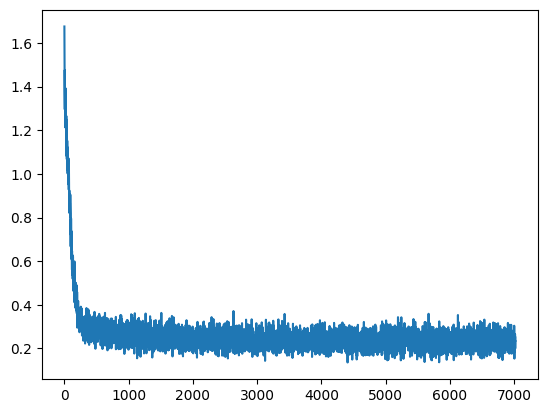

In [11]:
plt.plot(all_loss)

In [57]:
from sklearn.preprocessing import LabelEncoder
labels = [i[:2] for i in set(custom_pairs)]
le = LabelEncoder()
labels = le.fit_transform(labels)

In [58]:
labels

array([ 6, 13,  9,  9, 13,  6, 13,  5, 11, 11, 12,  2,  9, 16, 12, 10,  8,
        7, 11,  6,  6,  8,  6,  9, 11, 10,  9, 11,  9,  6, 11, 13, 11,  8,
       11,  7, 11,  2,  9, 10, 11, 14,  1, 13,  0,  7, 12, 11,  4,  9, 12,
       11,  8,  6, 10,  9,  9,  6, 11, 13,  9, 12, 12,  9, 11, 10, 11,  6,
       11, 12,  8, 13, 12,  9,  6,  6, 13, 10,  9,  4, 11, 10, 15,  9, 13,
        6, 11,  9,  6, 11,  9,  4,  5,  9,  6, 12, 11,  6,  6,  9,  6,  6,
        6, 11,  5,  5, 12, 12,  6, 12, 11,  4, 12,  7,  8,  9, 13, 12, 11,
       13, 12,  9, 12,  7, 11, 11, 11, 13, 12, 10, 13,  6,  6, 11,  6,  5,
       10,  6, 11,  9, 12,  8,  9, 10, 12, 13, 11,  6,  4, 13,  7, 12, 11,
       11,  7, 10,  9,  8,  6, 11,  8, 10,  8, 13,  5,  8,  8,  9, 12, 14,
        7,  3, 11,  6,  9, 13, 12,  7, 10,  6, 11, 11,  6, 14,  9,  6,  8,
        8,  5,  7, 11,  6,  6, 12, 10,  6,  6, 11,  6, 12,  6, 10, 13, 12,
        8])

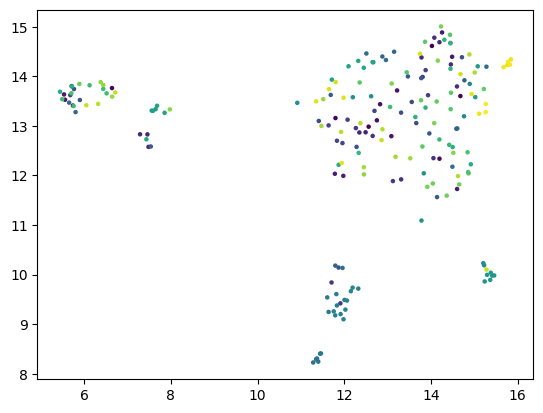

In [64]:
#import umap
w = encoder.embedding.question_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
## I am not sure how to map columns to column names, but here is based on ordering
plt.scatter(wp[:,0], wp[:,1], c=range(wp.shape[0]), s=5)
plt.show()

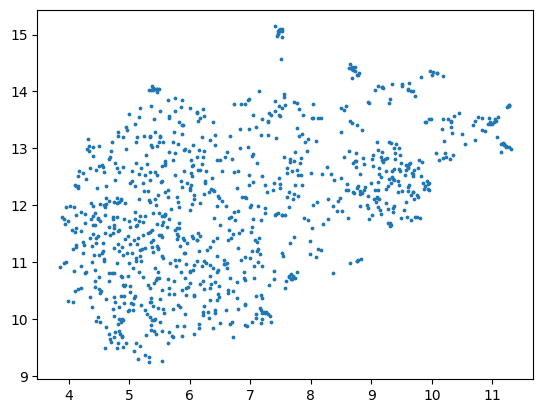

In [13]:
#import umap
w = encoder.embedding.answer_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
plt.scatter(wp[:,0], wp[:,1], s=3)
plt.show()

# Experimental Encoder (Only)

# Train the RNN

First we need to create Dataset class that can hold both the target (stored in a pd.DataFrame) and the sequences.

The sequences will be of dimension 14 x encoding_dimension, because we have 14 years of surveys.

I have created some code for getting the data into the right format, but it might not be useful.

## Regarding masks
Right now the masking is done already in the encoding. I haven't found exactly where Mikkel implemented this.
So for now, assume that nothing is padded, and then we'll figure it out with Mikkel.

In [17]:
# its not everyone we have a target for, so we do restrict the data to 
# the ones with known outcomes
targets = targets[targets.new_child.notna()]
train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)
train_person_ids, val_person_ids = train_test_split(train_person_ids, test_size=0.2, random_state=42)

In [18]:
rnn_data = {person_id: (
        torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
        torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
        )
        for person_id, wave_responses in sequences.items()
}

In [19]:
# split data based on the splits made for the target
train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
val_data = {person_id: rnn_data[person_id] for person_id in val_person_ids}
test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

In [20]:
len(custom_pairs), len(set(custom_pairs))

(250, 205)

In [21]:
from model.dataset import FinetuningDataset
train_dataset = FinetuningDataset(train_data, targets = targets)
val_dataset = FinetuningDataset(val_data, targets = targets)
test_dataset = FinetuningDataset(test_data, targets = targets)

rnn_batch_size = 10

train_dataloader = DataLoader(train_dataset, batch_size=rnn_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=rnn_batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=rnn_batch_size)

In [42]:
# ft - fine-tuning


SEQ_LEN = pretrain_dataset.get_seq_len()
VOCAB_SIZE = pretrain_dataset.get_vocab_size()

num_epochs_ft = 15
learning_rate_ft = 1e-3

encoder = TabularEncoder(vocab_size=VOCAB_SIZE, 
                         embedding_size=HIDDEN_SIZE, 
                         output_size=ENCODING_SIZE, 
                         num_layers=NUM_LAYERS, 
                         sequence_len=SEQ_LEN, 
                         layer_type = "mixture",
                         dropout=0.1,
                         dropout_embedding=0.1,
                         decoder_output=3).to(device)
encoder.load_state_dict(torch.load('weights/exp_9.pt'))

decoder = GRUDecoder(
    input_size=ENCODING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=3,
    max_seq_len=14,
    dropout=0.1,
    bidirectional=False,
    with_attention = True
).to(device)

# Define loss function and optimizer for RNN
ft_loss = nn.BCELoss()
ft_optimizer = torch.optim.NAdam(list(decoder.parameters()) + list(encoder.parameters()) , lr=learning_rate_ft, weight_decay=1e-3, decoupled_weight_decay=True)
ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = num_epochs_ft, eta_min = 1e-5, last_epoch = -1)

# Training loop
decoder.train()
encoder.train()
print("Ready!")

Embedding Layer with Question Embdeddings
Embedding Layer with the Dropout
Ready!


In [43]:
def run_validation():
    val_loss = []
    preds = []
    targets = []

    ## Set both models into the eval mode.=
    decoder.eval()
    encoder.eval()
    for batch in val_dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()


        # Forward pass
        xx = decoder(encodings, mask)
        outputs = F.sigmoid(xx).flatten()
        loss = ft_loss(outputs, labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(outputs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())

    # Concatenate all the batches
    probs = torch.tensor(preds).flatten()
    actuals = torch.tensor(targets).flatten()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), probs.cpu().numpy() > 0.5, average='binary')
    map_roc = average_precision_score(actuals.numpy(), probs.numpy())
    print(f"-- mAP Score: {map_roc:.4f} --")
    decoder.train()
    encoder.train()

In [44]:
loss_per_epoch = []
for epoch in range(num_epochs_ft):
    # print(epoch)
    loss_per_step = []
    loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    for i, batch in loop_object :        
        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()

        # Forward pass
        outputs = nn.functional.sigmoid(decoder(encodings, mask=mask))

        loss = ft_loss(torch.flatten(outputs), labels)  
        loss_per_step.append(loss.detach().cpu().numpy())
        loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_per_step[-100:]))

        #loss.backward(retain_graph=True)
        loss.backward()
        ft_optimizer.step()
    # On epoch end
    loss_per_epoch.append(np.mean(loss_per_step))
    ft_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs_ft}, Loss: {loss_per_epoch[-1]:.4f}")
    run_validation()
    

Epochs 0: 64it [00:13,  4.75it/s, mean loss: 0.524]


Epoch 1/15, Loss: 0.5235


/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-- mAP Score: 0.4822 --


Epochs 1: 64it [00:13,  4.75it/s, mean loss: 0.478]


Epoch 2/15, Loss: 0.4780
-- mAP Score: 0.3693 --


Epochs 2: 64it [00:13,  4.75it/s, mean loss: 0.405]


Epoch 3/15, Loss: 0.4049
-- mAP Score: 0.6206 --


Epochs 3: 64it [00:13,  4.80it/s, mean loss: 0.317]


Epoch 4/15, Loss: 0.3166
-- mAP Score: 0.6043 --


Epochs 4: 64it [00:13,  4.78it/s, mean loss: 0.290]


Epoch 5/15, Loss: 0.2896
-- mAP Score: 0.5983 --


Epochs 5: 64it [00:13,  4.79it/s, mean loss: 0.252]


Epoch 6/15, Loss: 0.2517
-- mAP Score: 0.6188 --


Epochs 6: 64it [00:13,  4.79it/s, mean loss: 0.191]


Epoch 7/15, Loss: 0.1909
-- mAP Score: 0.6100 --


Epochs 7: 64it [00:13,  4.78it/s, mean loss: 0.163]


Epoch 8/15, Loss: 0.1634
-- mAP Score: 0.6069 --


Epochs 8: 64it [00:13,  4.80it/s, mean loss: 0.120]


Epoch 9/15, Loss: 0.1205
-- mAP Score: 0.5831 --


Epochs 9: 64it [00:13,  4.74it/s, mean loss: 0.103]


Epoch 10/15, Loss: 0.1035
-- mAP Score: 0.6295 --


Epochs 10: 64it [00:13,  4.76it/s, mean loss: 0.066]


Epoch 11/15, Loss: 0.0664
-- mAP Score: 0.6465 --


Epochs 11: 64it [00:13,  4.77it/s, mean loss: 0.057]


Epoch 12/15, Loss: 0.0573
-- mAP Score: 0.6357 --


Epochs 12: 64it [00:13,  4.81it/s, mean loss: 0.041]


Epoch 13/15, Loss: 0.0412
-- mAP Score: 0.6415 --


Epochs 13: 64it [00:13,  4.81it/s, mean loss: 0.043]


Epoch 14/15, Loss: 0.0434
-- mAP Score: 0.6462 --


Epochs 14: 64it [00:13,  4.75it/s, mean loss: 0.037]


Epoch 15/15, Loss: 0.0366
-- mAP Score: 0.6359 --


In [45]:
test_loss = []
preds = []
targets = []

## Set both models into the eval mode.=
decoder.eval()
encoder.eval()
for batch in test_dataloader:
    inputs, labels = batch
    labels = labels.to(torch.float).to(device)

    input_year, input_seq = inputs
    bs, ss = labels.size(0), 14
    input_year = input_year.reshape(-1).to(device)
    input_seq = input_seq.reshape(bs * ss, -1).to(device)

    encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
    mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()


    # Forward pass
    xx = decoder(encodings, mask)
    outputs = F.sigmoid(xx).flatten()
    loss = ft_loss(outputs, labels)  
    test_loss.append(loss.detach().cpu().numpy())
    preds.extend(outputs.detach().cpu().numpy().tolist())
    targets.extend(labels.cpu().numpy().tolist())

# Concatenate all the batches
probs = torch.tensor(preds).flatten()
actuals = torch.tensor(targets).flatten()
# Concatenate all the batches

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), probs.cpu().numpy() > 0.5, average='binary')
map_roc = average_precision_score(actuals.numpy(), probs.numpy())
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"-- mAP Score: {map_roc:.4f} --")

Precision: 0.8378
Recall: 0.6200
F1 Score: 0.7126
-- mAP Score: 0.7330 --


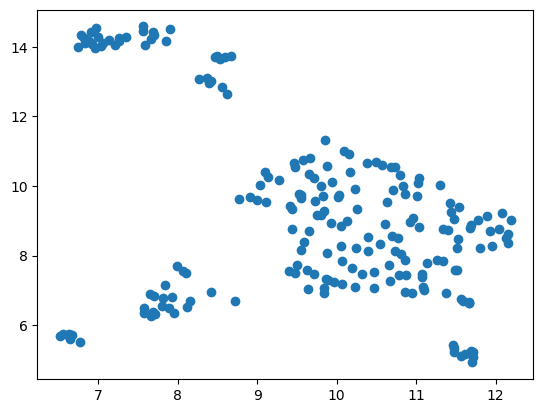

In [48]:
#import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
w = encoder.embedding.question_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
plt.scatter(wp[:,0], wp[:,1])
plt.show()

# Cross validation

In [ ]:
from model.dataset import FinetuningDataset
from model.dataset import PretrainingDataset
from sklearn.model_selection import KFold
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
targets = targets[targets.new_child.notna()].reset_index(drop=True)
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

In [ ]:
n_features = 100

importance = pd.read_csv('features_importance_1000.csv')
custom_pairs = importance.iloc[:n_features].feature.map(lambda x: get_generic_name(x))
sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)

rnn_data = {person_id: (
        torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
        torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
        )
        for person_id, wave_responses in sequences.items()
}

/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


In [ ]:
def initialize(HIDDEN_SIZE=64,
               ENCODING_SIZE=64,
               NUM_COLS=44,
               num_epochs_ft=5,
               learning_rate_ft=1e-3,
               sequences = []
               ):

    pretrain_dataset = PretrainingDataset(sequences)
    SEQ_LEN = pretrain_dataset.get_seq_len()
    VOCAB_SIZE = pretrain_dataset.get_vocab_size()

    encoder = TabularEncoder(vocab_size=VOCAB_SIZE, 
                             embedding_size=HIDDEN_SIZE, 
                             output_size=ENCODING_SIZE, 
                             num_layers=2, 
                             sequence_len=SEQ_LEN, 
                             layer_type = "excel",
                             num_cols=NUM_COLS,
                             dropout=0.1
                             ).to(device).to(device=device)

    decoder = GRUDecoder(
        input_size=ENCODING_SIZE,
        hidden_size=HIDDEN_SIZE,
        num_layers=2,
        max_seq_len=14,
        dropout=0.2,
        bidirectional=False,
        with_attention = True
    ).to(device)

    # Define loss function and optimizer for RNN
    ft_loss = nn.BCELoss()
    ft_optimizer = torch.optim.NAdam(list(decoder.parameters()) + list(encoder.parameters()) , lr=learning_rate_ft, weight_decay=1e-2, decoupled_weight_decay=True)
    ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = num_epochs_ft, eta_min = 1e-6, last_epoch = -1)

    # Training loop
    decoder.train()
    encoder.train()

    return encoder, decoder, ft_optimizer, ft_loss, ft_scheduler

In [ ]:

def evaluate_and_step(loop_object, encoder, decoder, ft_scheduler, ft_loss, ft_optimizer):
    for i, batch in loop_object :        

        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == NUM_COLS).view(bs,ss).detach()

        # Forward pass
        outputs = nn.functional.sigmoid(decoder(encodings, mask=mask))

        loss = ft_loss(torch.flatten(outputs), labels)  

        loss.backward()
        ft_optimizer.step()

    # On epoch end
    ft_scheduler.step()
    

In [ ]:
def evaluate(test_dataloader, encoder, decoder):
    val_loss = []
    preds = []
    targets = []

    ## Set both models into the eval mode.=
    decoder.eval()
    encoder.eval()
    for batch in test_dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == NUM_COLS).view(bs,ss).detach()

        # Forward pass
        xx = decoder(encodings, mask)
        outputs = torch.nn.functional.sigmoid(xx).flatten()
        loss = ft_loss(outputs, labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(outputs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())


    # Concatenate all the batches
    predictions = (torch.tensor(preds) > 0.5).float()
    probs = F.sigmoid(predictions)
    actuals = torch.tensor(targets).flatten()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
    map_roc = average_precision_score(actuals.numpy(), probs.numpy())
    
    return precision, recall, f1, map_roc
     


In [ ]:
HIDDEN_SIZE=64
ENCODING_SIZE=64
NUM_COLS=44
num_epochs_ft=10
learning_rate_ft=1e-3
rnn_batch_size = 10

n_splits = 4

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare for cross-validation
prec_per_fold = []
rec_per_fold = []
f1_per_fold = []
map_roc_per_fold = []

train_prec_per_fold = []
train_rec_per_fold = []
train_f1_per_fold = []
train_map_roc_per_fold = []

for fold, (train_index, val_index) in enumerate(kf.split(targets['nomem_encr'])):
    print(f'Fold: {fold}')
    train_person_ids = targets.loc[train_index, 'nomem_encr']
    test_person_ids = targets.loc[val_index, 'nomem_encr']
    
    encoder, decoder, ft_optimizer, ft_loss, ft_scheduler = initialize(
        HIDDEN_SIZE=64,
        ENCODING_SIZE=64,
        NUM_COLS=44,
        num_epochs_ft=1,
        learning_rate_ft=1e-3,
        sequences=sequences,
        )

    train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
    test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}
    
    train_dataset = FinetuningDataset(train_data, targets = targets)
    test_dataset = FinetuningDataset(test_data, targets = targets)

    train_dataloader = DataLoader(train_dataset, batch_size=rnn_batch_size, shuffle=True)
    test_dataloader  = DataLoader(test_dataset,  batch_size=rnn_batch_size)
    

    for epoch in range(num_epochs_ft):
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    
        evaluate_and_step(loop_object, encoder, decoder, ft_scheduler, ft_loss, ft_optimizer)

    precision, recall, f1, map_roc = evaluate(test_dataloader, encoder, decoder)
    precision_train, recall_train, f1_train, map_roc_train = evaluate(train_dataloader, encoder, decoder)
    
    prec_per_fold.append(precision)
    rec_per_fold.append(recall)
    f1_per_fold.append(f1)
    map_roc_per_fold.append(map_roc)

    train_prec_per_fold.append(precision_train)
    train_rec_per_fold.append(recall_train)
    train_f1_per_fold.append(f1_train)
    train_map_roc_per_fold.append(map_roc_train)


Fold: 0


Epochs 0: 74it [00:14,  5.09it/s]
Epochs 1: 74it [00:09,  8.13it/s]
Epochs 2: 74it [00:09,  7.96it/s]
Epochs 3: 74it [00:09,  7.82it/s]
Epochs 4: 74it [00:09,  8.01it/s]
Epochs 5: 74it [00:09,  7.93it/s]
Epochs 6: 74it [00:09,  8.12it/s]
Epochs 7: 74it [00:09,  8.19it/s]
Epochs 8: 74it [00:08,  8.25it/s]
Epochs 9: 74it [00:08,  8.38it/s]


Fold: 1


Epochs 0: 74it [00:08,  8.30it/s]
Epochs 1: 74it [00:08,  8.26it/s]
Epochs 2: 74it [00:08,  8.33it/s]
Epochs 3: 74it [00:09,  8.14it/s]
Epochs 4: 74it [00:09,  7.91it/s]
Epochs 5: 74it [00:08,  8.26it/s]
Epochs 6: 74it [00:08,  8.25it/s]
Epochs 7: 74it [00:08,  8.37it/s]
Epochs 8: 74it [00:08,  8.31it/s]
Epochs 9: 74it [00:09,  8.01it/s]


Fold: 2


Epochs 0: 74it [00:09,  7.96it/s]
Epochs 1: 74it [00:08,  8.23it/s]
Epochs 2: 74it [00:09,  8.01it/s]
Epochs 3: 74it [00:08,  8.27it/s]
Epochs 4: 74it [00:08,  8.33it/s]
Epochs 5: 74it [00:09,  8.06it/s]
Epochs 6: 74it [00:09,  8.20it/s]
Epochs 7: 74it [00:09,  7.96it/s]
Epochs 8: 74it [00:09,  8.05it/s]
Epochs 9: 74it [00:09,  8.19it/s]


Fold: 3


Epochs 0: 75it [00:09,  8.07it/s]
Epochs 1: 75it [00:09,  8.03it/s]
Epochs 2: 75it [00:09,  8.11it/s]
Epochs 3: 75it [00:09,  8.24it/s]
Epochs 4: 75it [00:09,  8.26it/s]
Epochs 5: 75it [00:09,  8.13it/s]
Epochs 6: 75it [00:09,  8.12it/s]
Epochs 7: 75it [00:09,  8.16it/s]
Epochs 8: 75it [00:09,  8.28it/s]
Epochs 9: 75it [00:09,  8.27it/s]


In [31]:
print("Results on test set")
print("Prec:", ' '.join(f"{x:.3f}" for x in prec_per_fold))
print("Recall:", ' '.join(f"{x:.3f}" for x in rec_per_fold))
print("f1:", ' '.join(f"{x:.3f}" for x in f1_per_fold))
print("map roc:", ' '.join(f"{x:.3f}" for x in map_roc_per_fold))

Results on test set
Prec: 0.783 0.714 0.844 0.552
Recall: 0.310 0.490 0.731 0.941
f1: 0.444 0.581 0.784 0.696
map roc: 0.405 0.455 0.674 0.531


In [32]:
print('Results on training set')
print("Prec:", ' '.join(f"{x:.3f}" for x in train_prec_per_fold))
print("Recall:", ' '.join(f"{x:.3f}" for x in train_rec_per_fold))
print("f1:", ' '.join(f"{x:.3f}" for x in train_f1_per_fold))
print("map roc:", ' '.join(f"{x:.3f}" for x in train_map_roc_per_fold))

Results on training set
Prec: 0.978 0.964 0.901 0.708
Recall: 0.565 0.839 0.912 0.963
f1: 0.716 0.897 0.907 0.816
map roc: 0.643 0.844 0.841 0.689
